# House price predictions

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

pd.set_option('display.max_columns', 100)

### Loading some premade code preprocessing

In [2]:
#Displays all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
#turns categorical object type features into Pandas Caetegory types.
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

# Loading Data

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# Exploring data

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
#There are 79 columns which can affect Sale price (exlucind ID)
len(train_df.columns)

81

In [7]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Variables to check and fix

In [8]:
for column in train_df:
    columnSeriesObj = train_df[column]
    print('Colunm Name : ', column)
    print('dtype: ', columnSeriesObj.dtype)
    print('Missing: ', len(train_df[columnSeriesObj.isnull()]))
    print('Unique: ', columnSeriesObj.unique())
    print('\n')

Colunm Name :  Id
dtype:  int64
Missing:  0
Unique:  [   1    2    3 ... 1458 1459 1460]


Colunm Name :  MSSubClass
dtype:  int64
Missing:  0
Unique:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]


Colunm Name :  MSZoning
dtype:  object
Missing:  0
Unique:  ['RL' 'RM' 'C (all)' 'FV' 'RH']


Colunm Name :  LotFrontage
dtype:  float64
Missing:  259
Unique:  [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]


Colunm Name :  LotArea
dtype:  int64
Missing:  0
Unique:  

In [9]:
#Check which columns have missing values
nulls = train_df.isnull().sum()
nulls[nulls > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [10]:
#Check which columns have missing values
nulls = test_df.isnull().sum()
nulls[nulls > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [11]:
display_all(train_df.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [13]:
train_df.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

## Preprocessing

In [14]:
#1 Features to drop
drop_features = ['PoolQC', 'Alley', 'Fence', 'FireplaceQu', 'MiscFeature' ]

#2 Numeric features - replace missing with Median values
rep_miss_with_median = ['LotFrontage','MasVnrArea','GarageYrBlt','TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2',
                       'BsmtFullBath', 'BsmtHalfBath','GarageCars','GarageArea']

#3 Categorical feature - replace missing with Most common values + Add extra column if feature was missing?
rep_miss_with_common = ['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                        'Electrical','GarageType','GarageFinish','GarageQual','GarageCond','MSZoning','Utilities','Exterior1st',
                       'Exterior2nd','KitchenQual','Functional','SaleType' ]


#4 Convert floats to int
to_integer = ['GarageYrBlt','LotFrontage','MasVnrArea']



#4 Convert objects/categorical to numeric 

to_numeric = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition']

In [15]:
data = [train_df, test_df]

In [16]:
#drop unnecessary features
for df in data:
    for feature in drop_features:
        del df[feature]

In [17]:
#replace missing values with median 
for df in data:
    for column in rep_miss_with_median:
        df[column].fillna(df[column].median(), inplace = True)
        
#add extra collumn that it was missing?

In [18]:
#replace missing values with most common + add extra collumn that it was missing
for df in data:
    for column in rep_miss_with_common:
        df[column].fillna(df[column].value_counts().index[0],inplace = True)

In [19]:
#Convert floats to int
for df in data:
    for column in to_integer:
        df[column] = df[column].astype(int)

In [20]:
#4 Convert objects/categorical to numeric 
#turns categorical object type features into Pandas Caetegory types.
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()



In [21]:
#o - 
test_df.SaleType.dtype

dtype('O')

In [22]:
train_cats(train_df)

In [23]:
train_cats(test_df)

In [24]:
test_df.MSZoning

0       RH
1       RL
2       RL
3       RL
4       RL
        ..
1454    RM
1455    RM
1456    RL
1457    RL
1458    RL
Name: MSZoning, Length: 1459, dtype: category
Categories (5, object): [C (all) < FV < RH < RL < RM]

In [25]:
#4 Convert objects/categorical to numeric  - Round 2
for df in data:
    for column in to_numeric:
        df[column] = df[column].cat.codes

In [26]:
test_df.MSZoning

0       2
1       3
2       3
3       3
4       3
       ..
1454    4
1455    4
1456    3
1457    3
1458    3
Name: MSZoning, Length: 1459, dtype: int8

## Model Training, Validation, Predictions

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [28]:
test_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPo

In [29]:
target = 'SalePrice'
features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], train_size = None)

In [55]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=100)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [56]:
train_score = m.score(X_train, y_train)
test_score = m.score(X_test,y_test)
print(f'Train score {train_score} \nTest score {test_score}')

Train score 0.9823279841239048 
Test score 0.82343129376863


In [62]:
X = test_df[features]
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80,11622,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,0,10,12,2,0,3,4,1,3,3,3,4,468.0,3,144.0,270.0,882.0,0,4,1,3,896,0,0,896,0.0,0.0,1,0,2,1,3,5,6,0,1,1961,2,1.0,730.0,3,4,2,140,0,0,0,120,0,0,6,2010,8,4
1,20,3,81,14267,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,0,11,13,1,108,3,4,1,3,3,3,0,923.0,5,0.0,406.0,1329.0,0,4,1,3,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,6,0,1,1958,2,1.0,312.0,3,4,2,393,36,0,0,0,0,12500,6,2010,8,4
2,60,3,74,13830,1,0,3,0,4,0,8,2,2,0,4,5,5,1997,1998,1,0,10,12,2,0,3,4,2,2,3,3,2,791.0,5,0.0,137.0,928.0,0,2,1,3,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,6,1,1,1997,0,2.0,482.0,3,4,2,212,34,0,0,0,0,0,3,2010,8,4
3,60,3,78,9978,1,0,3,0,4,0,8,2,2,0,4,6,6,1998,1998,1,0,10,12,1,20,3,4,2,3,3,3,2,602.0,5,0.0,324.0,926.0,0,0,1,3,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,6,1,1,1998,0,2.0,470.0,3,4,2,360,36,0,0,0,0,0,6,2010,8,4
4,120,3,43,5005,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,0,6,6,2,0,2,4,2,2,3,3,0,263.0,5,0.0,1017.0,1280.0,0,0,1,3,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,6,0,1,1992,1,2.0,506.0,3,4,2,0,82,0,0,144,0,0,1,2010,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,21,1936,1,3,3,0,4,0,10,2,2,3,4,4,7,1970,1970,1,0,5,5,2,0,3,4,1,3,3,3,5,0.0,5,0.0,546.0,546.0,0,2,1,3,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,6,0,1,1979,2,0.0,0.0,3,4,2,0,0,0,0,0,0,0,6,2006,8,4
1455,160,4,21,1894,1,3,3,0,4,0,10,2,2,4,4,4,5,1970,1970,1,0,5,5,2,0,3,4,1,3,3,3,4,252.0,5,0.0,294.0,546.0,0,4,1,3,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,6,0,4,1970,2,1.0,286.0,3,4,2,0,24,0,0,0,0,0,4,2006,8,0
1456,20,3,160,20000,1,3,3,0,4,0,11,2,2,0,2,5,7,1960,1996,1,0,10,12,2,0,3,4,1,3,3,3,0,1224.0,5,0.0,0.0,1224.0,0,0,1,3,1224,0,0,1224,1.0,0.0,1,0,4,1,3,7,6,1,5,1960,2,2.0,576.0,3,4,2,474,0,0,0,0,0,0,9,2006,8,0
1457,85,3,62,10441,1,3,3,0,4,0,11,2,2,0,5,5,5,1992,1992,1,0,6,14,2,0,3,4,2,2,3,0,2,337.0,5,0.0,575.0,912.0,0,4,1,3,970,0,0,970,0.0,1.0,1,0,3,1,3,6,6,0,1,1979,2,0.0,0.0,3,4,2,80,32,0,0,0,0,700,7,2006,8,4


In [63]:
price_predictions = m.predict(X)

In [59]:
# save houseId for final submission
houseId = test_df.Id

# dataframe with predictions
kaggle = pd.DataFrame({'Id': houseId, 'SalePrice': price_predictions})

# save to csv
kaggle.to_csv('iowa_house_price_prediction.csv', index=False)

In [60]:
importances = m.feature_importances_

Feature ranking:
1. feature 15 (0.539838)
2. feature 44 (0.119314)
3. feature 36 (0.054053)
4. feature 32 (0.031498)
5. feature 42 (0.024061)
6. feature 52 (0.021953)
7. feature 58 (0.021940)
8. feature 41 (0.020574)
9. feature 59 (0.017099)
10. feature 3 (0.015955)
11. feature 47 (0.015205)
12. feature 17 (0.009911)
13. feature 57 (0.007946)
14. feature 18 (0.006422)
15. feature 2 (0.005859)
16. feature 10 (0.005704)
17. feature 28 (0.005445)
18. feature 35 (0.005205)
19. feature 63 (0.004967)
20. feature 24 (0.004744)
21. feature 64 (0.004264)
22. feature 56 (0.003775)
23. feature 16 (0.003417)
24. feature 51 (0.003397)
25. feature 54 (0.002904)
26. feature 70 (0.002902)
27. feature 1 (0.002793)
28. feature 31 (0.002744)
29. feature 25 (0.002719)
30. feature 49 (0.002233)
31. feature 73 (0.002083)
32. feature 5 (0.001750)
33. feature 30 (0.001710)
34. feature 22 (0.001614)
35. feature 21 (0.001487)
36. feature 0 (0.001439)
37. feature 55 (0.001388)
38. feature 39 (0.001375)
39. featu

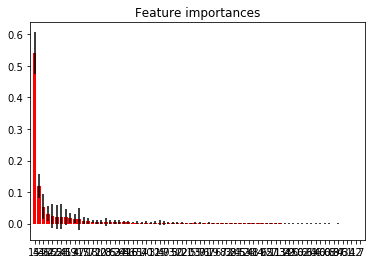

In [66]:
std = np.std([tree.feature_importances_ for tree in m.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()